# Pipline

In [ ]:
class model_pipeline:
    def __init__(self, df_path):
        """Initialize pipeline with dataset"""

        self.df = pd.read_csv(df_path)

    def df_summary(self):
        """Print dataset summary"""

        print("DATA HEAD")

        display(self.df.head())

        print("\nFEATURE TYPE")
        display(self.df.info())

    def drop_duplicates(self):
        self.df['from_account_id'] = self.df['From Bank'].astype(str) + '_' + self.df['Account'].astype(str)
        self.df['to_account_id'] = self.df['To Bank'].astype(str) + '_' + self.df['Account.1'].astype(str)

        df = df.reset_index(drop=True)
        from_nodes = df["from_account_id"].drop_duplicates().reset_index(drop=True)
        to_nodes = df["to_account_id"].drop_duplicates().reset_index(drop=True)
        all_nodes = pd.concat([from_nodes, to_nodes]).drop_duplicates().reset_index(drop=True)

    def add_date_features(self, date_column="Timestamp"):
        """Extract date features"""

        self.df['Timestamp'] = pd.to_datetime(self.df['Timestamp'])

        self.df["time_of_day"] = self.df["Timestamp"].dt.time
        self.df["hour_of_day"] = self.df["Timestamp"].dt.hour
        self.df["day_of_week"] = self.df["Timestamp"].dt.weekday # 0=Monday,...,6=Sunday
        self.df["seconds_since_midnight"] = (
            self.df["Timestamp"].dt.hour * 3600 +  # Convert hours to seconds
            self.df["Timestamp"].dt.minute * 60 +  # Convert minutes to seconds
            self.df["Timestamp"].dt.second         # Keep seconds
        )

        # Transform timestamp to raw int unix
        self.df["timestamp_int"] = self.df["Timestamp"].astype(int) / 10**9

        # Just a temp assignment, will be scaled later on
        self.df["timestamp_scaled"] = self.df["Timestamp"].astype(int) / 10**9

        # Apply cyclical encoding
        self.df["day_sin"] = np.sin(2 * np.pi * self.df["day_of_week"] / 7)
        self.df["day_cos"] = np.cos(2 * np.pi * self.df["day_of_week"] / 7)
        self.df["time_of_day_sin"] = np.sin(2 * np.pi * self.df["seconds_since_midnight"] / 86400)
        self.df["time_of_day_cos"] = np.cos(2 * np.pi * self.df["seconds_since_midnight"] / 86400)

        # Create binary weekend indicator
        self.df["is_weekend"] = self.df["day_of_week"].isin([5, 6]).astype(int)

        self.df.drop(columns=['Timestamp'], inplace= True)

    def apply_label_encoding(self, categorical_features):
        """Label encode categorical columns"""

        for col in categorical_features:
            self.df[col] = LabelEncoder().fit_transform(self.df[col])

    def numerical_scaling(self, numerical_features):
        """Standardize Numerical Features"""

        std_scaler = StandardScaler()

        self.X_train[numerical_features] = std_scaler.fit_transform(self.X_train[numerical_features])
        self.X_test[numerical_features] = std_scaler.transform(self.X_test[numerical_features])
        self.X_val[numerical_features] = std_scaler.transform(self.X_val[numerical_features])

        return self.X_train, self.X_test, self.X_val

    def extract_graph_features(self, weight_col):
        """Generate graph-based neighborhood context features"""

        G = nx.DiGraph()
        for _, row in self.df.iterrows():
            G.add_edge(row["Account"], row["Account.1"], weight=row[weight_col])

        # Add centrality and pagerank as features
        self.df["degree_centrality"] = self.df["Account"].map(nx.degree_centrality(G))
        self.df["pagerank"] = self.df["Account"].map(nx.pagerank(G))

    def generate_tensors(self, edge_features, edges = ["Account", "Account.1"]):
        """Convert data to PyTorch tensor format for GNNs"""

        def create_pyg_data(X, y):
            node_features = torch.tensor(X[edge_features].values, dtype=torch.float)

            labels = torch.tensor(y.values, dtype=torch.long)

            edge_index = torch.tensor(X[edges].values.T, dtype=torch.long)

            return Data(x=node_features, edge_index=edge_index, y=labels)

        # Create PyTorch Geometric datasets for train, validation, and test
        self.train_data = create_pyg_data(self.X_train, self.y_train)
        self.val_data = create_pyg_data(self.X_val, self.y_val)
        self.test_data = create_pyg_data(self.X_test, self.y_test)

        return self.train_data, self.val_data, self.test_data

    def split_train_test(self, X_cols, y_col, test_size=0.2):
        """Perform Train-Test Split"""

        X = self.df[X_cols]
        y = self.df[y_col]
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(
            X, y, test_size=test_size, random_state=42, stratify=y
        )

        return self.X_train, self.X_test, self.y_train, self.y_test

    def split_train_test_val(self, X_cols, y_col, test_size=0.15, val_size=0.15):
        """Perform Train-Test-Validation Split"""

        X = self.df[X_cols]
        y = self.df[y_col]

        self.X_train, X_temp, self.y_train, y_temp = train_test_split(
            X, y, test_size=(test_size + val_size), random_state=42, stratify=y
        )
        self.X_val, self.X_test, self.y_val, self.y_test = train_test_split(
            X_temp, y_temp, test_size=test_size / (test_size + val_size), random_state=42, stratify=y_temp
        )

        return self.X_train, self.X_val, self.X_test, self.y_train, self.y_val, self.y_test

    def result_metrics_train_test_split(self, y_test, y_pred, y_proba=None, class_labels=None):
        """
        Compute and display model performance metrics.

        Parameters:
        - y_test: True labels
        - y_pred: Predicted labels
        - y_proba: Predicted probabilities (for AUC-ROC & PR curve)
        - class_labels: List of class names (default: inferred from y_test)

        Returns:
        - metrics_dict: Dictionary containing key evaluation metrics
        """

        print("Classification Report:")
        print(classification_report(y_test, y_pred, digits=4))

        # Confusion Matrix
        cm = confusion_matrix(y_test, y_pred)
        accuracy = balanced_accuracy_score(y_test, y_pred)
        mcc = matthews_corrcoef(y_test, y_pred)
        logloss = log_loss(y_test, y_proba) if y_proba is not None else None

        print(f"Balanced Accuracy: {accuracy:.4f}")
        print(f"Matthews Correlation Coefficient (MCC): {mcc:.4f}")
        if logloss:
            print(f"Log Loss: {logloss:.4f}")

        # If class labels are not provided, generate default ones
        if class_labels is None:
            class_labels = [f"Class {i}" for i in range(len(set(y_test)))]

        # If probability predictions exist, compute ROC & PR AUC
        if y_proba is not None:
            # Binary classification
            if len(y_proba.shape) == 1:
                fpr, tpr, _ = roc_curve(y_test, y_proba)
                roc_auc = roc_auc_score(y_test, y_proba)
                precision, recall, _ = precision_recall_curve(y_test, y_proba)
                pr_auc = auc(recall, precision)
            else:  # Multi-class case
                fpr, tpr, _ = roc_curve(y_test, y_proba[:, 1])
                roc_auc = roc_auc_score(y_test, y_proba[:, 1])
                precision, recall, _ = precision_recall_curve(y_test, y_proba[:, 1])
                pr_auc = auc(recall, precision)


            print(f"AUC-ROC Score: {roc_auc:.4f}")
            print(f"Precision-Recall AUC: {pr_auc:.4f}")

        # Visualization
        fig, axes = plt.subplots(1, 3, figsize=(18, 5))

        # Confusion Matrix Plot
        sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0])
        axes[0].set_title("Confusion Matrix")
        axes[0].set_xlabel("Predicted Label")
        axes[0].set_ylabel("True Label")
        axes[0].set_xticklabels(class_labels)
        axes[0].set_yticklabels(class_labels)

        # ROC Curve Plot
        if y_proba is not None:
            axes[1].plot(fpr, tpr, label=f'ROC AUC = {roc_auc:.4f}')
            axes[1].plot([0, 1], [0, 1], linestyle="--", color="gray")  # Baseline
            axes[1].set_title("ROC Curve")
            axes[1].set_xlabel("False Positive Rate")
            axes[1].set_ylabel("True Positive Rate")
            axes[1].legend()

            # Precision-Recall Curve
            axes[2].plot(recall, precision, label=f'PR AUC = {pr_auc:.4f}')
            axes[2].set_title("Precision-Recall Curve")
            axes[2].set_xlabel("Recall")
            axes[2].set_ylabel("Precision")
            axes[2].legend()

        plt.tight_layout()
        plt.show()

    def result_metrics(self, slide_title, y_train, y_train_pred, y_train_proba,
                       y_val, y_val_pred, y_val_proba,
                       y_test, y_test_pred, y_test_proba,
                       class_labels=None):
        """
        Compute and display model performance metrics for train, validation, and test sets.
        """

        def compute_metrics(y_true, y_pred, y_proba):
            """ Compute key classification metrics """
            cm = confusion_matrix(y_true, y_pred)
            accuracy = balanced_accuracy_score(y_true, y_pred)
            mcc = matthews_corrcoef(y_true, y_pred)
            logloss = log_loss(y_true, y_proba) if y_proba is not None else None
            precision = precision_score(y_true, y_pred, average='binary')
            recall = recall_score(y_true, y_pred, average='binary')

            if y_proba is not None:
                fpr, tpr, _ = roc_curve(y_true, y_proba[:, 1] if len(y_proba.shape) > 1 else y_proba)
                roc_auc = roc_auc_score(y_true, y_proba[:, 1] if len(y_proba.shape) > 1 else y_proba)
                precision_curve, recall_curve, _ = precision_recall_curve(y_true, y_proba[:, 1] if len(y_proba.shape) > 1 else y_proba)
                pr_auc = auc(recall_curve, precision_curve)
            else:
                fpr, tpr, roc_auc, precision_curve, recall_curve, pr_auc = None, None, None, None, None, None

            return {
                "confusion_matrix": cm,
                "accuracy": accuracy,
                "mcc": mcc,
                "log_loss": logloss,
                "precision": precision,
                "recall": recall,
                "roc_curve": (fpr, tpr),
                "roc_auc": roc_auc,
                "precision_recall_curve": (precision_curve, recall_curve),
                "pr_auc": pr_auc
            }

        # Compute metrics for train, validation, and test sets
        train_metrics = compute_metrics(y_train, y_train_pred, y_train_proba)
        val_metrics = compute_metrics(y_val, y_val_pred, y_val_proba)
        test_metrics = compute_metrics(y_test, y_test_pred, y_test_proba)

        dataset_names = ["Train", "Validation", "Test"]
        metrics_dicts = [train_metrics, val_metrics, test_metrics]

        # Create figure for **3 rows, 4 columns**
        fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(24, 12))
        fig.suptitle(slide_title, fontsize=20, fontweight="bold")

        for i, (name, metrics) in enumerate(zip(dataset_names, metrics_dicts)):
            cm, roc_curve_vals, pr_curve_vals = metrics["confusion_matrix"], metrics["roc_curve"], metrics["precision_recall_curve"]

            # Confusion Matrix (Column 1)
            sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i, 0])
            axes[i, 0].set_title(f"{name} Set - Confusion Matrix", fontsize=14, fontweight="bold")
            axes[i, 0].set_xlabel("Predicted Label", fontsize=12)
            axes[i, 0].set_ylabel("True Label", fontsize=12)

            # ROC Curve (Column 2)
            if metrics["roc_auc"] is not None:
                fpr, tpr = roc_curve_vals
                axes[i, 1].plot(fpr, tpr, label=f'ROC AUC = {metrics["roc_auc"]:.4f}')
                axes[i, 1].plot([0, 1], [0, 1], linestyle="--", color="gray")  # Baseline
                axes[i, 1].set_title(f"{name} Set - ROC Curve", fontsize=14, fontweight="bold")
                axes[i, 1].legend(fontsize=12)

            # Precision-Recall Curve (Column 3)
            if metrics["pr_auc"] is not None:
                precision, recall = pr_curve_vals
                axes[i, 2].plot(recall, precision, label=f'PR AUC = {metrics["pr_auc"]:.4f}')
                axes[i, 2].set_title(f"{name} Set - Precision-Recall Curve", fontsize=14, fontweight="bold")
                axes[i, 2].legend(fontsize=12)

            # Convert None values to "N/A" before formatting
            log_loss_value = f"{metrics['log_loss']:.4f}" if metrics["log_loss"] is not None else "N/A"
            roc_auc_value = f"{metrics['roc_auc']:.4f}" if metrics["roc_auc"] is not None else "N/A"
            pr_auc_value = f"{metrics['pr_auc']:.4f}" if metrics["pr_auc"] is not None else "N/A"

            # Text-based Metrics (Column 4)
            metrics_text = (
                f"Balanced Accuracy: {metrics['accuracy']:.4f}\n"
                f"MCC: {metrics['mcc']:.4f}\n"
                f"Precision: {metrics['precision']:.4f}\n"
                f"Recall: {metrics['recall']:.4f}\n"
                f"Log Loss: {log_loss_value}\n"
                f"AUC-ROC: {roc_auc_value}\n"
                f"PR AUC: {pr_auc_value}"
            )
            axes[i, 3].text(0.1, 0.5, metrics_text, fontsize=14, ha="left", va="center", family="monospace", fontweight="bold")
            axes[i, 3].axis("off")  # Hide axis lines for text box

        plt.subplots_adjust(hspace=0.3, wspace=0.3)  # Better spacing for presentation
        plt.tight_layout(rect=[0, 0, 1, 0.96])  # Adjust layout for title
        plt.show()


# Weight Based

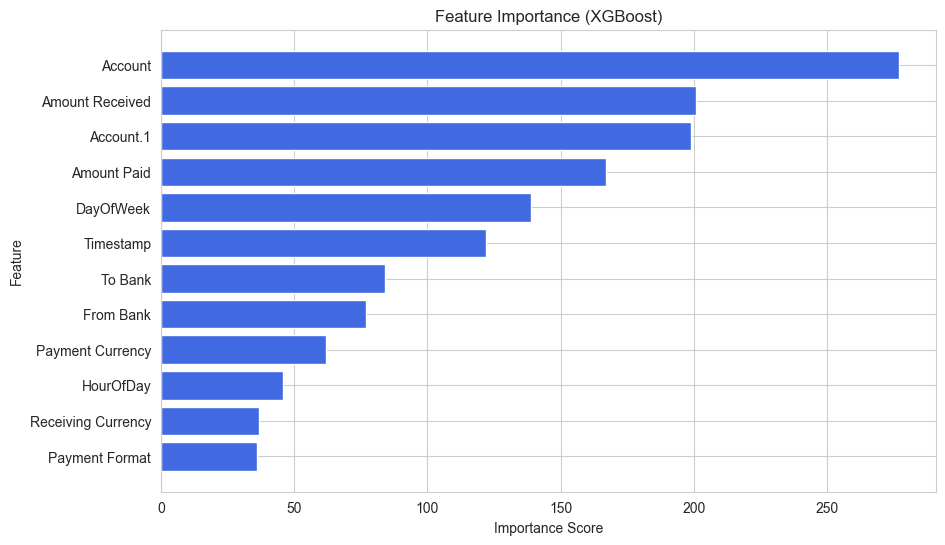

               Feature  Importance
2              Account       277.0
5      Amount Received       201.0
4            Account.1       199.0
7          Amount Paid       167.0
10           DayOfWeek       139.0
0            Timestamp       122.0
3              To Bank        84.0
1            From Bank        77.0
8     Payment Currency        62.0
11           HourOfDay        46.0
6   Receiving Currency        37.0
9       Payment Format        36.0


In [9]:
import numpy as np
import pandas as pd
import pickle
import json
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, recall_score, precision_score, precision_recall_curve, auc
from catboost import CatBoostClassifier

# Load Dataset
file_path = "/Users/zoujingyi/Desktop/EDA/HI-Small_Trans.csv"
df = pd.read_csv(file_path)

import pandas as pd
import xgboost as xgb
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Convert Timestamp to datetime and extract time-based features
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df['DayOfWeek'] = df['Timestamp'].dt.dayofweek  # 0 = Monday, 6 = Sunday
df['HourOfDay'] = df['Timestamp'].dt.hour  # Hour of the day (0-23)

# Identify categorical columns
categorical_cols = ['Account', 'Account.1', 'Payment Currency', 'From Bank', 'To Bank',
                    'Receiving Currency', 'Payment Format']

# Convert categorical columns to category codes
for col in categorical_cols:
    df[col] = df[col].astype('category').cat.codes


X = df.drop(columns=['Is Laundering'])  # Remove target variable
y = df['Is Laundering']  # Define target


# Convert Timestamp to Unix time
X['Timestamp'] = X['Timestamp'].astype(int) / 10**9

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 6,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

model = xgb.train(params, dtrain, num_boost_round=50)

# Extract feature importance
feature_importance = model.get_score(importance_type='weight')
feature_importance_df = pd.DataFrame({'Feature': feature_importance.keys(), 'Importance': feature_importance.values()})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='royalblue')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.title('Feature Importance (XGBoost)')
plt.gca().invert_yaxis()  # Highest importance on top
plt.show()

# Display feature importance scores
print(feature_importance_df)

# Permutation Feature Importance (Sklearn)

/Users/zoujingyi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:35:10] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


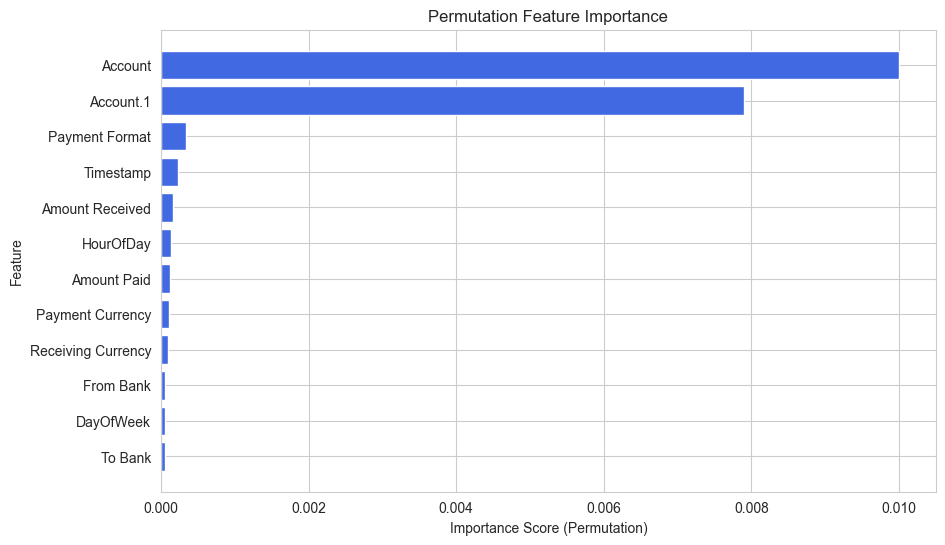

               Feature  Importance
2              Account    0.010001
4            Account.1    0.007906
9       Payment Format    0.000341
0            Timestamp    0.000231
5      Amount Received    0.000157
11           HourOfDay    0.000131
7          Amount Paid    0.000128
8     Payment Currency    0.000112
6   Receiving Currency    0.000098
1            From Bank    0.000060
10           DayOfWeek    0.000060
3              To Bank    0.000049


In [10]:
from sklearn.inspection import permutation_importance

# Train an XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False)
model.fit(X_train, y_train)

# Compute Permutation Feature Importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

# Sort and plot feature importance
importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': result.importances_mean})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='royalblue')
plt.xlabel('Importance Score (Permutation)')
plt.ylabel('Feature')
plt.title('Permutation Feature Importance')
plt.gca().invert_yaxis()
plt.show()

# Display scores
print(importance_df)

# SHAP (SHapley Additive exPlanations)

/Users/zoujingyi/anaconda3/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [12:37:08] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
100%|===================| 1015196/1015669 [28:07<00:00]       

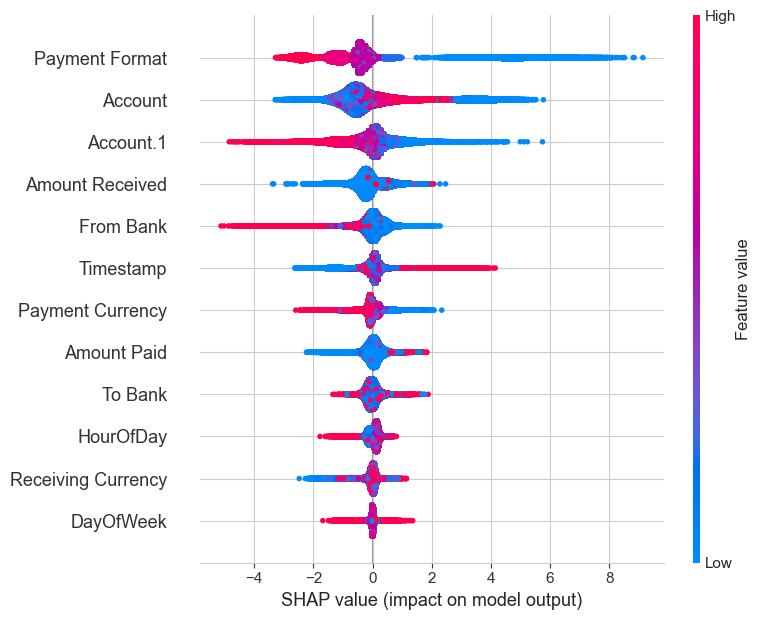

In [13]:
import shap

# Train an XGBoost model
model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='auc', use_label_encoder=False)
model.fit(X_train, y_train)

# Compute SHAP values
explainer = shap.Explainer(model, X_train)
shap_values = explainer(X_test, check_additivity=False)  # Add this flag

# Plot global feature importance
shap.summary_plot(shap_values, X_test)


# Gain-Based Feature Importance

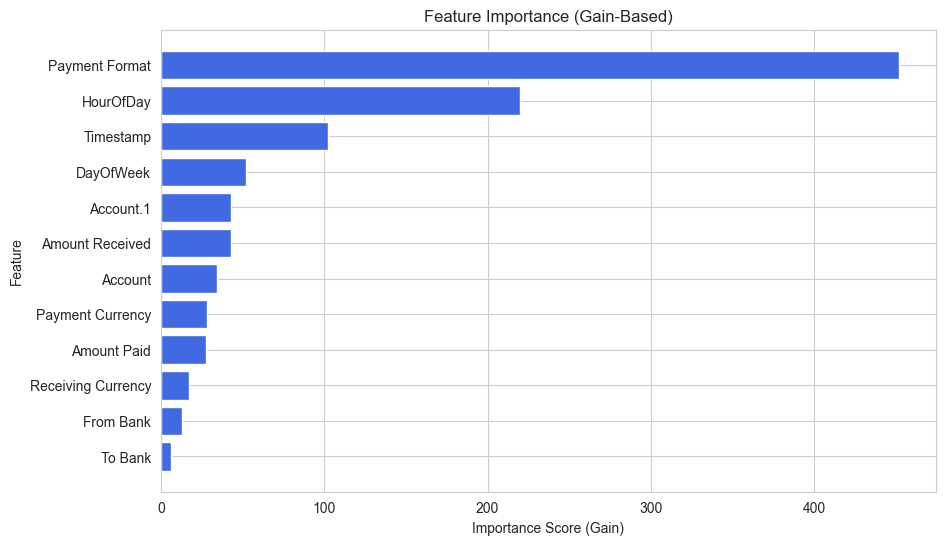

               Feature  Importance
9       Payment Format  451.834961
11           HourOfDay  220.014420
0            Timestamp  102.026176
10           DayOfWeek   52.212833
4            Account.1   43.199478
5      Amount Received   43.031372
2              Account   34.408630
8     Payment Currency   27.997608
7          Amount Paid   27.485617
6   Receiving Currency   17.149399
1            From Bank   12.663134
3              To Bank    6.250872


In [12]:
# Train XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
model = xgb.train(params, dtrain, num_boost_round=50)

# Extract Gain-based importance
importance_gain = model.get_score(importance_type='gain')
importance_df = pd.DataFrame({'Feature': importance_gain.keys(), 'Importance': importance_gain.values()})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='royalblue')
plt.xlabel('Importance Score (Gain)')
plt.ylabel('Feature')
plt.title('Feature Importance (Gain-Based)')
plt.gca().invert_yaxis()
plt.show()

print(importance_df)

# New features

## Weight Based + Gain Based

<Figure size 1200x800 with 0 Axes>

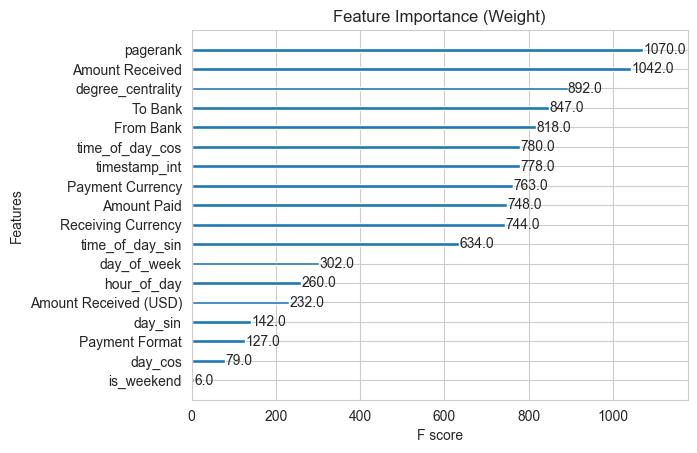

<Figure size 1200x800 with 0 Axes>

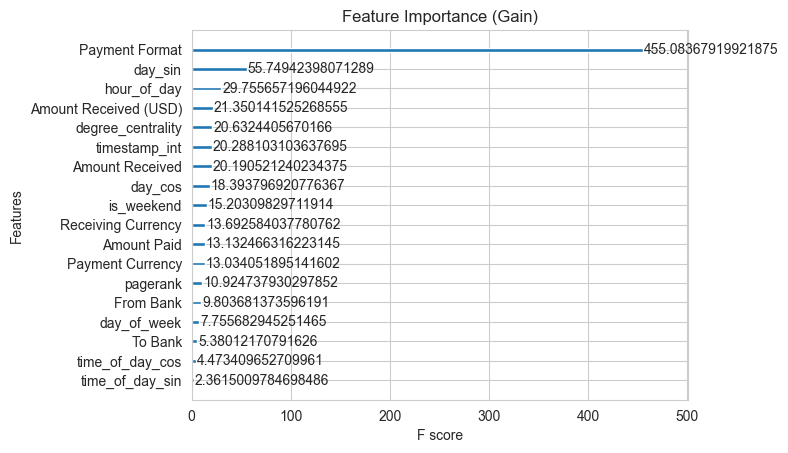

In [3]:
import numpy as np
import pandas as pd
import xgboost as xgb
import networkx as nx
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import plot_importance
import json

# ---------------------------
# 1. Load Data and Engineer Features
# ---------------------------
# Load dataset (update path if needed)
df = pd.read_csv("/Users/zoujingyi/Desktop/EDA/HI-Small_Trans.csv")

# --- Time-based Features ---
df['Timestamp'] = pd.to_datetime(df['Timestamp'], errors='coerce')
df['hour_of_day'] = df['Timestamp'].dt.hour
df['day_of_week'] = df['Timestamp'].dt.weekday  # 0=Monday, ... 6=Sunday
df['seconds_since_midnight'] = (df['Timestamp'].dt.hour * 3600 +
                                df['Timestamp'].dt.minute * 60 +
                                df['Timestamp'].dt.second)
# Cyclical encoding for day_of_week and time_of_day
df['day_sin'] = np.sin(2 * np.pi * df['day_of_week'] / 7)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_week'] / 7)
df['time_of_day_sin'] = np.sin(2 * np.pi * df['seconds_since_midnight'] / 86400)
df['time_of_day_cos'] = np.cos(2 * np.pi * df['seconds_since_midnight'] / 86400)
# Create binary weekend indicator
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
# Unix timestamp (if needed)
df['timestamp_int'] = df['Timestamp'].astype(np.int64) // 10**9

# ---------------------------
# 2. Currency Conversion
# ---------------------------
usd_conversion = {'USD': 1.0, 'EUR': 1.1, 'GBP': 1.3, 'JPY': 0.009}  # Example conversion rates
if 'Amount Received' in df.columns and 'Receiving Currency' in df.columns:
    df['Amount Received (USD)'] = df.apply(
        lambda row: row['Amount Received'] / usd_conversion.get(row['Receiving Currency'], 1.0),
        axis=1
    )
else:
    df.rename(columns={"Amount Received (USD)": "Amount Received (USD)"}, inplace=True)

# ---------------------------
# 3. Graph-based Features
# ---------------------------
# Build directed graph using sender "Account" and receiver "Account.1"
G = nx.DiGraph()
for _, row in df.iterrows():
    # Only add edge if both sender and receiver are present
    if pd.notna(row['Account']) and pd.notna(row['Account.1']):
        weight = row.get('Amount Received (USD)', 1)
        G.add_edge(row['Account'], row['Account.1'], weight=weight)

# Compute centrality and PageRank
deg_cent = nx.degree_centrality(G)
prank = nx.pagerank(G)
df['degree_centrality'] = df['Account'].map(deg_cent).fillna(0)
df['pagerank'] = df['Account'].map(prank).fillna(0)

# ---------------------------
# 4. Drop Unnecessary Columns
# ---------------------------
# Remove columns that are not to be used in the model
# Drop original Timestamp and seconds_since_midnight (if not needed)
df.drop(columns=['Timestamp', 'seconds_since_midnight'], inplace=True)
# Drop the raw account identifiers
df.drop(columns=['Account', 'Account.1'], inplace=True)

# ---------------------------
# 5. Standardize Numerical Features
# ---------------------------
# Identify numerical features (excluding the target column 'Is Laundering')
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Is Laundering' in num_cols:
    num_cols.remove('Is Laundering')

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# ---------------------------
# 6. Define Features and Target
# ---------------------------
# Assume the target column is named "Is Laundering"
X = df.drop(columns=['Is Laundering'])
y = df['Is Laundering']

# ---------------------------
# 7. Convert Object Columns to Categorical dtype
# ---------------------------
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype('category')

# ---------------------------
# 8. Split Data into Train and Test
# ---------------------------
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# ---------------------------
# 9. Train XGBoost Model with Categorical Support
# ---------------------------
# Create DMatrix objects with enable_categorical=True (requires XGBoost v1.5.0+)
dtrain = xgb.DMatrix(X_train, label=y_train, enable_categorical=True)
dtest = xgb.DMatrix(X_test, label=y_test, enable_categorical=True)

params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'max_depth': 8,
    'eta': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}

bst = xgb.train(params, dtrain, num_boost_round=100)

# ---------------------------
# 10. Feature Importance Plots
# ---------------------------
# Weight-based Feature Importance
plt.figure(figsize=(12, 8))
plot_importance(bst, importance_type='weight', max_num_features=20, title="Feature Importance (Weight)")
plt.savefig("/Users/zoujingyi/Desktop/EDA/feature_importance_weight.png")
plt.show()

# Gain-based Feature Importance
plt.figure(figsize=(12, 8))
plot_importance(bst, importance_type='gain', max_num_features=20, title="Feature Importance (Gain)")
plt.savefig("/Users/zoujingyi/Desktop/EDA/feature_importance_gain.png")
plt.show()
